# PROJECT. Исследование поведения пользователей мобильной игры  Quiz Freeze.
## ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении. Проверить 3 гипотезы:
- Влияет ли обучение на скорость прохождения других этапов игры;
- Влияет ли повторное прохождение обучения положительно на оплату;
- Если пользователь сначала выбирает сложность вопросов, будет ли он потом проходить обучение.

## ЗАДАЧИ
В рамках проверки гипотез необходимо решить три задачи:
- Определить, насколько обучение сокращает время прохождения этапов игры.
- Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
- Определить, насколько прозрачен процесс взаимодействия с игрой.
## КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ)
- Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
- Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
- Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна)
## ОБЩИЕ СВЕДЕНИЯ
Источниками данных являются таблицы Event и Purchase, хранящие данные о действиях пользователей в игре Quiz Freeze.
Анализ проводится на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).
Рассматриваемые группы пользователей: окончившие обучение и не проходившие обучение.

Таблица Event

Хранит данные о событиях, которые совершают пользователи:
* id	идентификатор события
* user_id	уникальный идентификатор пользователя, совершившего событие в приложении
* start_time	дата и время события
* event_type	тип события (значения: registration — регистрация; tutorial_start — начало обучения; tutorial_finish — завершение обучения; level_choice — выбор уровня сложности; pack_choice — выбор пакетов вопросов)
* tutorial_id	идентификатор обучения (этот идентификатор есть только у событий обучения)
* selected_level	выбранный уровень сложности обучения

Таблица Purchase

Хранит данные об оплатах, которые совершают пользователи:
* id	идентификатор события
* user_id	уникальный идентификатор пользователя, совершившего событие в приложении
* event_datetime	дата и время события/покупки
* amount	сумма оплаты


### ШАГ 1. Получаем данные и проводим их обзор и преобразование

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go


In [37]:
import plotly.io as pio
pio.renderers
pio.renderers.default = "colab"

In [2]:
# Загружаем csv-файлы 7_4_Events.csv и purchase.csv
events_df = pd.read_csv('data/game/7_4_Events.csv', sep = ',')
purchase_df = pd.read_csv('data/game/purchase.csv', sep = ',')

In [3]:
# Получим общую информацию о датафрейме, для того чтобы оценить, 
# какие данные содержатся в датафрейме events_df
events_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB


Датафрейм events_df содержит 252334 строки и шесть столбцов. При этом все строки содержат значения в столбцах id, user_id, start_time, event_type, а столбцы selected_level и  tutorial_id содержат пропущенные значения.
Столбец start_time имеет тип данных object и для дальнейшего исследования нам необходимо будет перевести его в тип данных datetime.

In [4]:
# получим общую информацию о датафрейме, для того чтобы оценить, 
# какие данные содержатся в датафрейме purchase_df
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB


Датафрейм не содержит пропусков, вся информация содержится в 4 столбцах id, user_id, event_datetime, amount. Для дальнейшего исследования нам необходимо будет перевести столбец event_datetime в тип datetime.

In [5]:
# Делаем выборку пользователей, зарегистрировавшихся 2018 году 
cond = (events_df.start_time>='2018-01-01') & (events_df.start_time<'2019-01-01') & (events_df.event_type=='registration')
# Список пользователей, зарегистрировавшихся в 2018
registered = events_df[cond]['user_id'].to_list()
# Сохраняем полученный срез в переменную events
events = events_df[events_df.user_id.isin(registered)].copy()
# Преобразуем тип данных столбца start_time в datetime
events.start_time = pd.to_datetime(events.start_time, format='%Y-%m-%dT%H:%M:%S') 
# Делаем выборку оплаты событий, совершенных пользователями, зарегистрировавшихся 2018 году
purchase = purchase_df[purchase_df['user_id'].isin(registered)].copy()
# Изменим тип столбца  event_datetime на datetime
purchase.event_datetime = pd.to_datetime(purchase.event_datetime, format='%Y-%m-%dT%H:%M:%S')

In [6]:
# Перед объединением датафреймов, переименуем колонки
events = events.rename(columns={'id':'event_id'})
purchase = purchase.rename(columns={'id':'purchase_id'})
# Добавим в датафрейм purchase столбец event_type, который будет содержать одно значение purchase.
# Это нужно, чтобы в объединённом датафрейме однозначно выделить события оплаты.
purchase['event_type'] = 'purchase'
# Сделаем объединенный датафрейм из событий и оплат
total_events_df = pd.concat([events,purchase],sort=False)
print(total_events_df.head(5))

       event_id    event_type selected_level          start_time  tutorial_id  \
51405   80308.0  registration            NaN 2018-01-01 03:48:40          NaN   
51406   80309.0  registration            NaN 2018-01-01 04:07:25          NaN   
51407   80310.0  registration            NaN 2018-01-01 08:35:10          NaN   
51408   80311.0  registration            NaN 2018-01-01 11:54:47          NaN   
51409   80312.0  registration            NaN 2018-01-01 13:28:07          NaN   

       user_id  purchase_id event_datetime  amount  
51405    27832          NaN            NaT     NaN  
51406    27833          NaN            NaT     NaN  
51407    27834          NaN            NaT     NaN  
51408    27835          NaN            NaT     NaN  
51409    27836          NaN            NaT     NaN  


### ШАГ 2. Выделим отдельные группы пользователей и посмотрим, сколько доходит до каждого этапа

In [7]:
# Выделим отдельные группы пользователей
registrated_users = set(events[events['event_type'] == 'registration']['user_id'])
tutorial_started_users = set(events[events['event_type'] == 'tutorial_start']['user_id'])
tutorial_finish_users = set(events[events['event_type'] == 'tutorial_finish']['user_id'])
tutorial_not_started_users = registrated_users - tutorial_started_users
level_choice_users = set(events[events['event_type'] == 'level_choice']['user_id'])
pack_choice_users = set(events[events['event_type'] == 'pack_choice']['user_id'])
purchase_users = set(purchase['user_id'])
purchase_users_start_tut = purchase[purchase['user_id'].isin(tutorial_started_users)]
purchase_users_not_start_tut = purchase[purchase['user_id'].isin(tutorial_not_started_users)]

Посмотрим на количество пользователей, дошедших до каждого этапа

In [8]:
stages = ['Количество зарегистрировавшихся','Количество начинавших обучение','Количество окончивших обучение',\
         'Количество не начинавших обучение', 'Количество выбравших уровень', 'Количество выбравших пакет вопросов',\
         'Количество оплативших', 'Количество оплат-ших и проходивших обучение', 'Количество оплат-ших и не проходивших обучение']
counts = [len(registrated_users),len(tutorial_started_users),len(tutorial_finish_users),\
        len(tutorial_not_started_users),len(level_choice_users), len(pack_choice_users), len(purchase_users), len(purchase_users_start_tut), len(purchase_users_not_start_tut)]

for i in range(len(stages)):
    print(f'{stages[i]:47}:{str(counts[i]):>10} :{round(counts[i]/counts[0]*100, 2):>10} %')

Количество зарегистрировавшихся                :     19926 :     100.0 %
Количество начинавших обучение                 :     11858 :     59.51 %
Количество окончивших обучение                 :     10250 :     51.44 %
Количество не начинавших обучение              :      8068 :     40.49 %
Количество выбравших уровень                   :      8342 :     41.86 %
Количество выбравших пакет вопросов            :      5737 :     28.79 %
Количество оплативших                          :      1600 :      8.03 %
Количество оплат-ших и проходивших обучение    :      1578 :      7.92 %
Количество оплат-ших и не проходивших обучение :        22 :      0.11 %


In [38]:
trace = go.Funnel(
    y = stages,
    x = counts,
    textposition = "inside",
    textinfo = "value+percent initial",
    )
layout = go.Layout(
    title = "Воронка продаж для пользователей проходивших/не проходивших обучение",
    margin = {"l": 200, "r": 100})
    
fig = go.Figure(trace, layout)
fig.show()

### ШАГ 3. Проанализируем этапы прохождения игры

In [10]:
# Переименуем название столбца
total_events_df = total_events_df.rename(columns={'event_datetime':'start_time'})
# Создадим датафрейм с минимальным временем выбранного события, если событие могло произойти несколько раз
users_time_df = total_events_df.pivot_table(values=['start_time'], index=['user_id'], \
    columns=['event_type', ], aggfunc='min').copy()
print(len(users_time_df))
users_time_df.head()

19926


start_time                                          \
event_type        level_choice         pack_choice        registration   
user_id                                                                  
27832                      NaT                 NaT 2018-01-01 03:48:40   
27833                      NaT                 NaT 2018-01-01 04:07:25   
27834                      NaT                 NaT 2018-01-01 08:35:10   
27835      2018-01-01 20:37:22 2018-01-01 20:38:43 2018-01-01 11:54:47   
27836                      NaT                 NaT 2018-01-01 13:28:07   

                                                             
event_type     tutorial_finish      tutorial_start purchase  
user_id                                                      
27832                      NaT                 NaT      NaT  
27833      2018-01-01 17:50:08 2018-01-01 17:47:40      NaT  
27834      2018-01-01 19:48:01 2018-01-01 19:46:11      NaT  
27835      2018-01-01 15:06:15 2018-01-01 15:00:51      NaT  
27836      2018-01-01 15:42:58 2018-01-01 14:54:40      NaT

In [11]:
# Создадим сводную таблицу, где для каждого уникального пользователя в столбцах будет начало каждого этапа
users_time_df.reset_index(inplace=True)
users_time_df.columns=['user_id', 'level_choice', 'pack_choice', 'registration', 'tutorial_finish', 'tutorial_start', 'purchase']
users_time_df.head()

,user_id,level_choice,pack_choice,registration,tutorial_finish,tutorial_start,purchase
0,27832,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT
1,27833,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,NaT
2,27834,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,NaT
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,NaT
4,27836,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,NaT


In [12]:
# Добавим колонку с признаком группы
users_time_df['tutorial_group'] = users_time_df['user_id'].apply(lambda x: 'finished_tutorial' if x in tutorial_finish_users \
    else 'without_tutorial' if x in tutorial_not_started_users else 'others')
print(users_time_df.head())

   user_id        level_choice         pack_choice        registration  \
0    27832                 NaT                 NaT 2018-01-01 03:48:40   
1    27833                 NaT                 NaT 2018-01-01 04:07:25   
2    27834                 NaT                 NaT 2018-01-01 08:35:10   
3    27835 2018-01-01 20:37:22 2018-01-01 20:38:43 2018-01-01 11:54:47   
4    27836                 NaT                 NaT 2018-01-01 13:28:07   

      tutorial_finish      tutorial_start purchase     tutorial_group  
0                 NaT                 NaT      NaT   without_tutorial  
1 2018-01-01 17:50:08 2018-01-01 17:47:40      NaT  finished_tutorial  
2 2018-01-01 19:48:01 2018-01-01 19:46:11      NaT  finished_tutorial  
3 2018-01-01 15:06:15 2018-01-01 15:00:51      NaT  finished_tutorial  
4 2018-01-01 15:42:58 2018-01-01 14:54:40      NaT  finished_tutorial  


In [13]:
# Проверяем правильность формирования групп
count_finished = len(users_time_df[users_time_df['tutorial_group'] == 'finished_tutorial']['user_id'].unique())
count_not_started = len(users_time_df[users_time_df['tutorial_group'] == 'without_tutorial']['user_id'].unique())
count_other = len(users_time_df[users_time_df['tutorial_group'] == 'others']['user_id'].unique())
print(len(registrated_users) == count_finished + count_not_started + count_other)


True


In [14]:
# Создадим колонки, где рассчитаем время прохождения этапов
users_time_df['time_delta_purch'] = users_time_df['purchase'] - users_time_df['registration']
users_time_df['time_delta_pack_lev'] = users_time_df['pack_choice'] - users_time_df['level_choice']
users_time_df['time_delta_purch_pack'] = users_time_df['purchase'] - users_time_df['pack_choice']
users_time_df['time_delta_lev_reg'] = users_time_df['level_choice'] - users_time_df['registration']
print(f'Среднее время между регистрацией и оплатой', users_time_df.groupby('tutorial_group')['time_delta_purch'].apply(np.mean))
print()
print('***********************************')
print(f'Среднее время между регистрацией и выбором уровня', users_time_df.groupby('tutorial_group')['time_delta_lev_reg'].apply(np.mean))
print()
print('***********************************')
print(f'Среднее время между выбором уровня и выбором пакета вопросов', users_time_df.groupby('tutorial_group')['time_delta_pack_lev'].apply(np.mean))
print()
print('***********************************')
print(f'Среднее время между выбором пакета вопросов и оплатой', users_time_df.groupby('tutorial_group')['time_delta_purch_pack'].apply(np.mean))

Среднее время между регистрацией и оплатой tutorial_group
finished_tutorial   4 days 00:30:03.247408431
others              4 days 05:32:53.213740458
without_tutorial    4 days 09:06:01.909090909
Name: time_delta_purch, dtype: timedelta64[ns]

***********************************
Среднее время между регистрацией и выбором уровня tutorial_group
finished_tutorial   0 days 07:05:36.854819357
others              0 days 08:12:57.551816958
without_tutorial    0 days 05:15:33.122448979
Name: time_delta_lev_reg, dtype: timedelta64[ns]

***********************************
Среднее время между выбором уровня и выбором пакета вопросов tutorial_group
finished_tutorial   0 days 00:05:18.146058732
others              0 days 00:05:05.295687885
without_tutorial    0 days 00:05:23.824324324
Name: time_delta_pack_lev, dtype: timedelta64[ns]

***********************************
Среднее время между выбором пакета вопросов и оплатой tutorial_group
finished_tutorial   3 days 17:17:59.641326883
others         

In [15]:
# Приведем полученные значения к числовому формату
users_time_df['time_delta_purch'] = users_time_df['time_delta_purch']/pd.Timedelta('1 hour')
users_time_df['time_delta_pack_lev'] = users_time_df['time_delta_pack_lev']/ pd.Timedelta('1 hour')
users_time_df['time_delta_purch_pack'] = users_time_df['time_delta_purch_pack']/ pd.Timedelta('1 hour')
users_time_df['time_delta_lev_reg'] = users_time_df['time_delta_lev_reg']/ pd.Timedelta('1 hour')

In [16]:
intervals_name = ['регистрация => выбор уровня',
    'выбор уровня => выбор вопросов',
    'выбор вопросов => оплата',
    'регистрация => оплата']
mean_1 = round(users_time_df.groupby('tutorial_group')['time_delta_lev_reg'].mean(), 2)
mean_2 = round(users_time_df.groupby('tutorial_group')['time_delta_pack_lev'].mean(), 3)
mean_3 = round(users_time_df.groupby('tutorial_group')['time_delta_purch_pack'].mean(), 2)
mean_4 = round(users_time_df.groupby('tutorial_group')['time_delta_purch'].mean(), 2)
groups = list(users_time_df['tutorial_group'].unique())
for_finished_tutorial = []
for_without_totorial = []
for n in range(1, 5):
    exec(f"for_finished_tutorial.append(mean_{n}[0])")
    exec(f"for_without_totorial.append(mean_{n}[2])")
    

In [17]:
print('Для завершивших обучение, среднее время между этапами в часах')
print('========================')
for i in range(len(intervals_name)):
    print(f'{intervals_name[i]:35}:{str(for_finished_tutorial[i]):>25}')
print()
print('Для не начинавших обучение, среднее время между этапами в часах')
print('========================')
for i in range(len(intervals_name)):
    print(f"{intervals_name[i]:35}:{str(for_without_totorial[i]):>25}")

Для завершивших обучение, среднее время между этапами в часах
регистрация => выбор уровня        :                     7.09
выбор уровня => выбор вопросов     :                    0.088
выбор вопросов => оплата           :                     89.3
регистрация => оплата              :                     96.5

Для не начинавших обучение, среднее время между этапами в часах
регистрация => выбор уровня        :                     5.26
выбор уровня => выбор вопросов     :                     0.09
выбор вопросов => оплата           :                   100.83
регистрация => оплата              :                    105.1


In [39]:
fig = go.Figure(data=[
    go.Bar(
        name='Закончили обучение',
        x=intervals_name,
        y=for_finished_tutorial,
        text=for_finished_tutorial,
        textposition='auto',
        ),
    go.Bar(
        name='Не проходили обучение',
        x=intervals_name,
        y=for_without_totorial,
        text=for_without_totorial,
        textposition='auto',
        )
])
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray',)

# Change the bar mode
fig.update_layout(
    barmode='group',
#     margin = {"l": 100, "r": 100},
    title_text='Прохождение этапов группами пользователей, час.',
    xaxis=dict(
        title='Интервалы между этапами',
        titlefont_size=10,
        tickfont_size=8,
        ),
    yaxis=dict(
        title='Часы',
        titlefont_size=10,
        tickfont_size=8,
        ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)',
        ),
)
fig.show()

Посмотрим, сколько времени в среднем тратят пользователи, прошедшие обучение, на само обучение.

In [19]:
tutorial_time = users_time_df['tutorial_finish'] - users_time_df['tutorial_start'] 
print(f'Среднее время обучения: ', tutorial_time.mean())

Среднее время обучения:  0 days 00:12:13.823121951


Среднее время, потраченное на обучение (между первым tutorial_start и первым tutorial_finish) - 12 минут. Таким образом, само прохождение обучения практически не влияет на разницу в прохождении этапов для рассматриваемых групп пользователей.

### ШАГ 4. Анализ  зависимости между вероятностью оплаты и количеством обучений

На этом шаге мы проверим, гипотезу, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло

In [20]:
# Создадим датафрейм с событием начала обучения
start_tutorial_df = total_events_df[total_events_df['event_type'] == 'tutorial_start']
# Посчитаем, сколько раз проходили обучение пользователи
group_start = start_tutorial_df.groupby('user_id')['event_type'].agg(['count']).reset_index()
# Посчитаем количество пользователей в зависимости от попыток обучения
group_start_tut = group_start.groupby('count')['user_id'].count().reset_index()
print(group_start_tut)
# Объединим  датафрейм с событием начала обучения с датафреймом оплат
purch_start_df = start_tutorial_df.merge(purchase, on = 'user_id', how = 'inner')

   count  user_id
0      1     9103
1      2     1589
2      3      427
3      4      221
4      5      109
5      6      116
6      7       94
7      8       86
8      9      113


In [21]:
# Посчитаем  покупателей в зависимости от количества обучений
tutorial_tries = purch_start_df.groupby('user_id')['event_type_x'].agg(['count']).reset_index()
group_tutorial_tries = tutorial_tries.groupby(['count'])['user_id'].count().reset_index()
print(group_tutorial_tries)

   count  user_id
0      1     1207
1      2      218
2      3       51
3      4       30
4      5       16
5      6       14
6      7       12
7      8       13
8      9       17


In [22]:
# Процент оплативших из непроходивших обучение
purch_not_start_df = total_events_df[total_events_df['user_id'].isin(tutorial_not_started_users)].merge(purchase, on = 'user_id', how = 'inner')
count_purch_not_start_tut = purch_not_start_df['user_id'].nunique()
conversion_not_tutorial = count_purch_not_start_tut/len(tutorial_not_started_users)*100
print(f'Процент пользователей, оплативших тренировки и не проходивших обучение: {round(conversion_not_tutorial, 2)} %')

Процент пользователей, оплативших тренировки и не проходивших обучение: 0.27 %


In [23]:
# Посчитаем количество покупателей, начавших обучение
purchase_users_start_tutorial = purchase[purchase['user_id'].isin(tutorial_started_users)]
count_purchase_users_start_tutorial = purchase_users_start_tutorial['user_id'].nunique()
print(count_purchase_users_start_tutorial)

1578


In [24]:
# Процент покупателей, начавших обучение, в зависимости от количества начатых обучений, от общего количества покупателей,
# начинавших обучение
group_tutorial_tries['purch_tutorial_rate'] = group_tutorial_tries['user_id']/count_purchase_users_start_tutorial

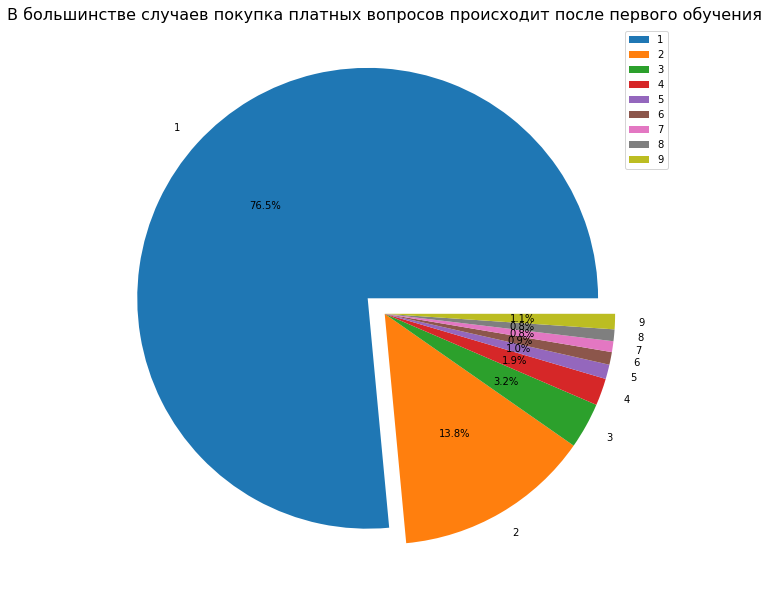

In [25]:
fig = plt.figure(figsize=(8, 8))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    group_tutorial_tries['purch_tutorial_rate'],
    labels=group_tutorial_tries['count'],
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0]
);
axes.set_title('В большинстве случаев покупка платных вопросов происходит после первого обучения', fontsize=16)
axes.legend()

In [26]:
# Посчитаем количество покупателей, начавших обучение
purchase_users_finish_tutorial = purchase[purchase['user_id'].isin(tutorial_finish_users)]
count_purchase_users_finish_tutorial = purchase_users_finish_tutorial['user_id'].nunique()
# Посмотрим, какая конверсия в покупку у пользователей, прошедших обучение
conversion_finish_tutorial = count_purchase_users_finish_tutorial/len(tutorial_finish_users)*100
print(f'Процент пользователей, оплативших тренировки и прошедших обучение: {round(conversion_finish_tutorial, 2)} %')

Процент пользователей, оплативших тренировки и прошедших обучение: 14.12 %


In [27]:
# Создадим общий датафрейм с количеством пользователей и покупателей в зависимости от количества начатых обучений 
merged_tutor_tries = group_start_tut.merge(group_tutorial_tries, on='count', how='inner')
# Переименуем одинаковые столбцы, получившиеся в результате объединения
merged_tutor_tries = merged_tutor_tries.rename(columns={'user_id_x': 'count_users', 'user_id_y': 'count_clients'})
# Добавим столбец с конверсией покупателей
merged_tutor_tries['conversion_%'] = round(merged_tutor_tries['count_clients']/merged_tutor_tries['count_users']*100, 2)
print(merged_tutor_tries)

   count  count_users  count_clients  purch_tutorial_rate  conversion_%
0      1         9103           1207             0.764892         13.26
1      2         1589            218             0.138150         13.72
2      3          427             51             0.032319         11.94
3      4          221             30             0.019011         13.57
4      5          109             16             0.010139         14.68
5      6          116             14             0.008872         12.07
6      7           94             12             0.007605         12.77
7      8           86             13             0.008238         15.12
8      9          113             17             0.010773         15.04


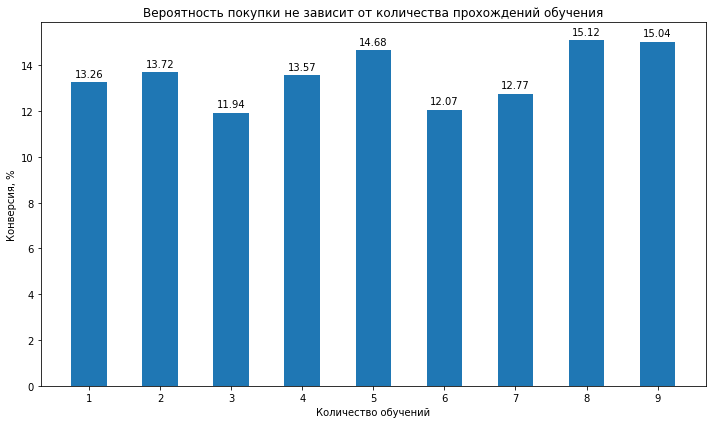

In [28]:
labels = list(merged_tutor_tries['count'])
x = np.arange(len(labels)) 
fig, ax = plt.subplots(figsize=(10, 6))
rects = ax.bar(x, merged_tutor_tries['conversion_%'], width= 0.5)
ax.set_xlabel('Количество обучений')
ax.set_ylabel('Конверсия, %')
ax.set_title('Вероятность покупки не зависит от количества прохождений обучения')
ax.set_xticks(x, labels)
ax.bar_label(rects, padding=3)
fig.tight_layout()
plt.show()

Независимо от того, сколько раз пользователи начинали и заканчивали обучение, конверсия распределена достаточно равномерно. Конверсия для группы пользователей, не начинавших обучение,  низкая (0,27%), поэтому можно утверждать, что прохождение обучения само по себе оказывает сильное влияние на вероятность оплаты.


### Шаг 5. Проверка, насколько часто пользователи начинают обучение после того, как они выбрали уровень сложности тренировок

Объединим два вспомогательных фрейма  tutorial_start_df  и choice_level_df по пользователям и посмотрим на разницу во времени.

In [29]:
tutorial_start_df = events[events['event_type'] == 'tutorial_start']
tutorial_start_df = tutorial_start_df[['user_id', 'start_time']].rename(columns={'start_time':'start_tutorial_time'})



In [30]:
choice_level_df = events[events['event_type'] =='level_choice']
choice_level_df = choice_level_df[['user_id', 'start_time']].rename(columns={'start_time': 'level_choice_time'})

In [31]:
merged_level_tutor = tutorial_start_df.merge(choice_level_df, how = 'inner', on = 'user_id')
print(merged_level_tutor.head())

   user_id start_tutorial_time   level_choice_time
0    27835 2018-01-01 15:00:51 2018-01-01 20:37:22
1    27839 2018-01-01 19:11:36 2018-01-01 22:37:50
2    27840 2018-01-02 02:07:07 2018-01-02 05:18:42
3    27845 2018-01-02 03:03:44 2018-01-02 06:19:18
4    27845 2018-01-02 07:08:00 2018-01-02 06:19:18


In [32]:
merged_level_tutor['time_delta'] = merged_level_tutor['start_tutorial_time'] - merged_level_tutor['level_choice_time']
print(merged_level_tutor.head())

   user_id start_tutorial_time   level_choice_time        time_delta
0    27835 2018-01-01 15:00:51 2018-01-01 20:37:22 -1 days +18:23:29
1    27839 2018-01-01 19:11:36 2018-01-01 22:37:50 -1 days +20:33:46
2    27840 2018-01-02 02:07:07 2018-01-02 05:18:42 -1 days +20:48:25
3    27845 2018-01-02 03:03:44 2018-01-02 06:19:18 -1 days +20:44:26
4    27845 2018-01-02 07:08:00 2018-01-02 06:19:18   0 days 00:48:42


Cтроки с положительным time_delta - это и есть необходимые нам события обучения после выбора уровня сложности.

In [33]:
merged_level_tutor['time_delta'] = merged_level_tutor['time_delta']/pd.Timedelta('1 hour')
users_after_level = merged_level_tutor[merged_level_tutor['time_delta'] > 0]['user_id'].nunique()


In [34]:
count_users_choice_level_df = choice_level_df['user_id'].nunique()
return_to_tutorial = round(users_after_level/count_users_choice_level_df*100, 2)

In [35]:
print(f"Количество пользователей, выбравших уровень сложности: {count_users_choice_level_df:>31}")
print(f"Количество пользователей, вернувшиеся к обучению после выбора уровня сложности: {users_after_level:>6}")
print(f"Процент вернувшихся к обучению пользователей: {return_to_tutorial:>38} %")

Количество пользователей, выбравших уровень сложности:                            8342
Количество пользователей, вернувшиеся к обучению после выбора уровня сложности:   1386
Процент вернувшихся к обучению пользователей:                                  16.61 %


# ВЫВОДЫ
## Задача 1: 
Среднее время между регистрацией и оплатой 

- Пользователи, окончившие обучение:                   4 days 00:30:03
- Пользователи, начавшие, но не закончившие обучение:  4 days 05:32:53
- Пользователи, не проходившие обучение:               4 days 09:06:02

***************

Среднее время между регистрацией и выбором уровня сложности

- Пользователи, окончившие обучение:                   0 days 07:05:37
- Пользователи, начавшие, но не закончившие обучение:  0 days 08:12:58
- Пользователи, не проходившие обучение:               0 days 05:15:33

****************

Среднее время между выбором уровня сложности и выбором пакета вопросов 

- Пользователи, окончившие обучение:                   0 days 00:05:18
- Пользователи, начавшие, но не закончившие обучение:  0 days 00:05:05
- Пользователи, не проходившие обучение:               0 days 00:05:23

****************

Среднее время между выбором пакета вопросов и оплатой 

- Пользователи, окончившие обучение:                    3 days 17:17:60
- Пользователи, начавшие, но не закончившие обучение:   3 days 21:14:47
- Пользователи, не проходившие обучение:                4 days 04:49:34

На само обучение в среднем пользователи тратят 12 минут.

Итого разница во времени прохождения всех этапов пользователями, проходившими обучение, по сравнению с пользователями, не начинавшими обучение, меньше на 8 часов 36 минут (примерно 9 %). Только на первоначальном этапе (регистрация - выбор уровня сложности) обучавшиеся пользователи тратят больше времени на 1 час 50 мин. А после прохождения обучения начинают незначительно опережать не проходивших обучение пользователей. Само обучение составляет всего лишь 12 минут в среднем, поэтому не влияет на разницу прохождения этапов сравниваемых групп.
Так как количество оплативших вопросы пользователей очень мало (всего 22 человека), то говорить однозначно, что время прохождения этапов зависит от факта прохождения обучения, нельзя.

## Задача 2:
Независимо от того, сколько раз пользователи начинали и заканчивали обучение, конверсия распределена достаточно равномерно. Конверсия для группы пользователей, не начинавших обучение,  низкая (0,27%), поэтому можно утверждать, что прохождение обучения оказывает сильное влияние на вероятность оплаты. Если сравнивать в зависимости от количества прохождения обучения, то самый высокий процент покупок (76,5 %) приходится на пользователей, проходивших обучение один раз, но это логично, так как данная группа самая многочисленная.

## Задача 3:

Всего пользователей, выбравших уровень сложности 8342. Количество пользователей, вернувшиеся к обучению после выбора уровня сложности 1386, что составляет 16.61 %. Это достаточно большое значение. И учитывая значительный отток пользователей, происходящий на каждом этапе (из 19926 зарегистрировавшихся человек до выбора уровня сложности доходят 8342, а до выбора вопросов 5737 человек), можно судить о том, что работа с приложением непонятна.
Также можно предположить, что само обучение недостаточно понятное, если пользователи возвращаются к обучению (около 23 %), некоторые по несколько раз.
